In [1]:
import torch
from markov_bridges.data.utils import sample_8gaussians
from markov_bridges.data.utils import sample_moons

from matplotlib import pyplot as plt

from torch.distributions import Dirichlet,Categorical
from markov_bridges.configs.config_classes.data.basics_configs import ColorMoonsConfig
import numpy as np

In [2]:
def plot_data(points, labels, title="Data Plot"):
    # Create a color map based on labels
    unique_labels = np.unique(labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))  # 'tab10' provides 10 distinct colors
    
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(unique_labels):
        # Filter points based on current label
        label_points = points[labels == label]
        plt.scatter(label_points[:, 0], label_points[:, 1], color=colors(i), label=f'Label {label}')
    
    plt.title(title)
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
    plt.grid(True)
    plt.show()

In [3]:
data_config = ColorMoonsConfig(total_data_size=3000)
data_config.discrete_dimensions

1

In [9]:
discrete_type = "dirichlet" #data_config.target_discrete_type

gaussians_xy,gaussian_labels = sample_8gaussians(data_config.total_data_size)


if discrete_type == "dirichlet":
    m = 8
    dirichlet_distribution = Dirichlet(torch.full((data_config.vocab_size,),data_config.target_dirichlet))
    gaussian_colors = torch.zeros((data_config.total_data_size,))
    for gaussian_index in range(m):
        where_index = torch.where(gaussian_labels ==  gaussian_index)[0]
        print(where_index.size(0))


    moons_xy,moons_labels = sample_moons(data_config.total_data_size)

discrete_type

380
384
369
395
352
383
385
352


'dirichlet'

In [5]:

colors_distribution_per_gaussian = dirichlet_distribution.sample((m,))

colors_distribution_per_gaussian

tensor([[6.7021e-01, 1.4018e-13, 3.2571e-01, 4.0815e-03],
        [2.2491e-02, 1.2579e-01, 6.3153e-01, 2.2019e-01],
        [3.3168e-02, 7.3900e-01, 2.2745e-01, 3.8283e-04],
        [1.4555e-11, 2.4424e-10, 1.0000e+00, 8.8990e-12],
        [5.1594e-02, 2.2385e-03, 4.7451e-12, 9.4617e-01],
        [2.9146e-08, 7.1200e-11, 7.5430e-01, 2.4570e-01],
        [4.4162e-01, 8.1522e-07, 5.5838e-01, 1.6223e-07],
        [8.7447e-03, 9.8836e-01, 5.0086e-09, 2.8911e-03]])

C:\Users\cesar\AppData\Local\Temp\ipykernel_32224\1113482976.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))  # 'tab10' provides 10 distinct colors


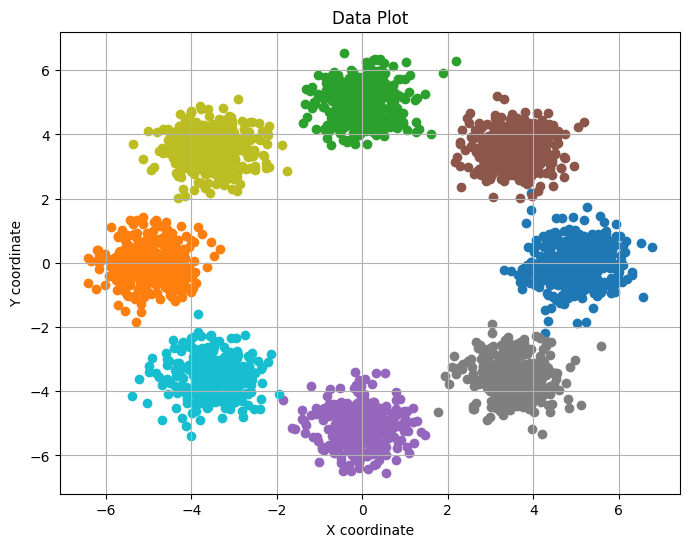

In [27]:
plot_data(gaussians_xy,gaussian_labels)

In [ ]:
from markov_bridges.data.

class GraphDataloader(MarkovBridgeDataloader):
    graph_config : GraphDataloaderGeometricConfig
    name:str = "GraphDataloader"
    max_node_num:int 
    expected_shape:List[int]

    def __init__(self,graph_config:GraphDataloaderGeometricConfig):
        """
        :param config:
        :param device:
        """
        self.graph_config = graph_config
        self.transform_list,self.inverse_transform_list = get_transforms(graph_config)
        self.get_dataloaders()

    def transform_to_native_shape(self,data:Union[GraphDataNameTuple,torch.Tensor])->Union[GraphDataNameTuple,torch.Tensor]:
        """
        """
        if isinstance(data,torch.Tensor):
            return self.inverse_transform_list(data)
        
        # Convert named tuple to a dictionary
        data_dict = data._asdict()
        DataNamedTuple = type(data) 

        # Update the dictionary entries
        data_dict['source_discrete'] = self.inverse_transform_list(data.source_discrete)
        data_dict['target_discrete'] = self.inverse_transform_list(data.target_discrete)

        # Convert the dictionary back to the named tuple
        updated_data = DataNamedTuple(**data_dict)
        return updated_data
    
    def networkx_from_sample(self,adj_matrices):
        # GET GRAPH FROM GENERATIVE MODEL
        graph_list = []
        number_of_graphs = adj_matrices.shape[0]
        adj_matrices = adj_matrices.detach().cpu().numpy()
        for graph_index in range(number_of_graphs):
            graph_ = nx.from_numpy_array(adj_matrices[graph_index])
            graph_list.append(graph_)
        return graph_list
    
    def get_dataloaders(self):
        """
        Creates the dataloaders
        """
        train_data,test_data = self.get_target_data(self.graph_config)

        self.dimension,self.expected_shape = get_expected_shape(self.max_node_num,
                                                                self.graph_config.flatten,
                                                                self.graph_config.full_adjacency)
        
        self.graph_config.temporal_net_expected_shape = self.expected_shape
        self.graph_config.number_of_nodes = self.max_node_num
        self.graph_config.discrete_dimensions = self.dimension

        train_data = self.get_data_divisions(train_data,self.graph_config)
        train_data = MarkovBridgeDataset(train_data)

        test_data = self.get_data_divisions(test_data,self.graph_config)
        test_data = MarkovBridgeDataset(test_data)

        self.train_dataloader = DataLoader(train_data, batch_size=self.graph_config.batch_size, shuffle=True)
        self.test_dataloader = DataLoader(test_data,batch_size=self.graph_config.batch_size, shuffle=True)

    def get_target_data(self,data_config:MarkovBridgeDataConfig):
        """
        reads the data files
        """
        train_graph_list, test_graph_list,max_number_of_nodes,min_number_of_nodes = self.read_graph_lists()
        train_data = graphs_to_tensor(train_graph_list,max_number_of_nodes)
        test_data = graphs_to_tensor(test_graph_list,max_number_of_nodes)

        self.max_node_num = max_number_of_nodes
        self.min_node_num = min_number_of_nodes

        return train_data,test_data
    
    def get_source_data(self,dataset,data_config:MarkovBridgeDataConfig):
        dataset_size = dataset.size(0)
        if data_config.source_discrete_type == "uniform":
            vocab_size = data_config.vocab_size
            NoiseDistribution = Categorical(torch.full((vocab_size,),1./vocab_size))
            noise_sample = NoiseDistribution.sample((dataset_size,self.dimension)).float()
            return noise_sample
        else:
            raise Exception("Source not Implemented")
    
    def get_data_divisions(self,dataset,data_config:MarkovBridgeDataConfig)->MarkovBridgeDataClass:
        """
        divides the data in the different context, source and target
        """
        # preprocess data
        target_discrete = self.transform_list(dataset)

        # source
        source_discrete = self.get_source_data(target_discrete,data_config)

        return MarkovBridgeDataClass(source_discrete=source_discrete,
                                     target_discrete=target_discrete)
    
    def read_graph_lists(self)->Tuple[List[nx.Graph]]:
        """
        :return: train_graph_list, test_graph_list
        """
        data_dir = self.graph_config.data_dir
        file_name = self.graph_config.dataset_name
        file_path = os.path.join(data_dir, file_name)
        with open(file_path + '.pkl', 'rb') as f:
            graph_list = pickle.load(f)
        test_size = int(self.graph_config.test_split * len(graph_list))

        all_node_numbers = list(map(lambda x: x.number_of_nodes(), graph_list))

        max_number_of_nodes = max(all_node_numbers)
        min_number_of_nodes = min(all_node_numbers)

        train_graph_list, test_graph_list = graph_list[test_size:], graph_list[:test_size]
        return train_graph_list, test_graph_list,max_number_of_nodes,min_number_of_nodes
